[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/01-numpy/numpy.ipynb)

In [ ]:
! curl -LsSf https://astral.sh/uv/install.sh | sh && \
  uv pip install -q --system "s26-06642 @ git+https://github.com/jkitchin/s26-06642.git"
from pycse.colab import pdf

```{index} NumPy, ndarray, numerical computing
```


# Module 01: NumPy Fundamentals

NumPy is the foundation of numerical computing in Python. Nearly every data science library builds on NumPy arrays.

## Learning Objectives

1. Create and manipulate NumPy arrays
2. Use vectorized operations (no loops!)
3. Apply broadcasting for efficient computation
4. Perform basic linear algebra
5. Read data from files and work with structured arrays
6. Generate random numbers for simulations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

```{index} vectorization, Python lists vs NumPy
```


## Why NumPy? The Foundation of Scientific Python

Before we dive in, it's worth understanding *why* NumPy exists and what problem it solves.

### The Problem with Python Lists

Python is a wonderful language, but it was designed for general-purpose programming, not numerical computing. Python lists are:

- **Flexible**: Can hold mixed types (`[1, "hello", 3.14]`)
- **Dynamic**: Can grow and shrink easily
- **Slow**: Each element is a full Python object with overhead

This flexibility comes at a cost. When you're doing numerical work—solving differential equations, processing spectra, training machine learning models—you need to perform the *same operation on millions of numbers*. Python's flexibility becomes a liability.

### NumPy's Solution

NumPy provides a new data type: the **ndarray** (n-dimensional array). NumPy arrays are:

- **Homogeneous**: All elements have the same type (e.g., all 64-bit floats)
- **Contiguous**: Stored in a single block of memory
- **Vectorized**: Operations apply to all elements at once, implemented in C

The result? NumPy can be 10-100x faster than Python lists for numerical operations.

### Why This Matters for Chemical Engineering

Almost everything we do involves arrays of numbers:
- Sensor data from reactors (time series of temperatures, pressures, flows)
- Concentration profiles from simulations
- Spectroscopic data (absorbance vs wavelength)
- Training data for machine learning models

NumPy is the foundation that Pandas, scikit-learn, TensorFlow, and virtually every scientific Python library builds upon. Master NumPy, and everything else becomes easier.

In [ ]:
# Speed comparison
python_list = list(range(1000000))
numpy_array = np.arange(1000000)

# Python list
%timeit [x**2 for x in python_list]

# NumPy array
%timeit numpy_array**2

19.2 ms ± 104 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


554 μs ± 5.33 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The timing results speak for themselves. On my machine, the NumPy operation is roughly **50-100x faster** than the Python list comprehension. For a million elements!

This difference compounds quickly:
- Processing 1 million data points: seconds vs minutes
- Training a machine learning model: minutes vs hours
- Running a Monte Carlo simulation: hours vs days

The speed difference comes from:
1. **Memory layout**: NumPy arrays are stored contiguously, enabling cache-efficient access
2. **Type consistency**: No type checking needed for each element
3. **Compiled code**: Operations run in optimized C/Fortran, not interpreted Python

This is why every scientific Python library uses NumPy under the hood.

```{index} array creation, np.array, np.zeros, np.ones, np.linspace, np.arange
```


## Creating Arrays: Choosing the Right Approach

There are many ways to create NumPy arrays, and the right choice depends on your situation:

| Situation | Method | Example |
|-----------|--------|---------|
| From existing data | `np.array()` | Converting a Python list |
| Initialize to zeros | `np.zeros()` | Pre-allocating for a loop |
| Initialize to ones | `np.ones()` | Creating masks or weights |
| Evenly spaced values | `np.linspace()` | Plotting a function |
| Integer sequence | `np.arange()` | Loop indices |
| Random values | `np.random.uniform()` | Monte Carlo simulation |

**Pro tip**: Avoid growing arrays in loops. If you know the final size, pre-allocate with `np.zeros()` and fill in values. This is much faster than appending.

In [ ]:
# From Python list
concentrations = np.array([0.1, 0.2, 0.5, 1.0, 2.0])  # mol/L
print("Concentrations:", concentrations)
print("Type:", type(concentrations))
print("Shape:", concentrations.shape)
print("Dtype:", concentrations.dtype)

Concentrations: [0.1 0.2 0.5 1.  2. ]
Type: <class 'numpy.ndarray'>
Shape: (5,)
Dtype: float64


In [ ]:
# Common array creation functions
zeros = np.zeros(5)
ones = np.ones(5)
temps = np.linspace(300, 500, 5)  # 5 evenly spaced points from 300 to 500
pressures = np.arange(1, 11, 2)   # From 1 to 11, step 2

print("Zeros:", zeros)
print("Ones:", ones)
print("Temperatures:", temps)
print("Pressures:", pressures)

Zeros: [0. 0. 0. 0. 0.]
Ones: [1. 1. 1. 1. 1.]
Temperatures: [300. 350. 400. 450. 500.]
Pressures: [1 3 5 7 9]


In [ ]:
# 2D arrays (matrices)
# Experimental data: rows = experiments, columns = [T, P, yield]
experiments = np.array([
    [300, 1.0, 45.2],
    [350, 1.5, 52.8],
    [400, 2.0, 68.1],
    [450, 2.5, 75.4],
    [500, 3.0, 82.0]
])

print("Shape:", experiments.shape)  # (5 rows, 3 columns)
print("\nExperiment data:")
print(experiments)

Shape: (5, 3)

Experiment data:
[[300.    1.   45.2]
 [350.    1.5  52.8]
 [400.    2.   68.1]
 [450.    2.5  75.4]
 [500.    3.   82. ]]


```{index} indexing, slicing, advanced indexing
```


## Indexing and Slicing: Accessing Your Data

NumPy's indexing is one of its most powerful features. Understanding it well will save you countless hours of writing loops.

### The Key Insight

In Python, you typically write loops to process data. In NumPy, you **describe what you want**, and NumPy figures out how to get it efficiently.

Instead of:
```python
result = []
for i in range(len(data)):
    if data[i] > threshold:
        result.append(data[i])
```

You write:
```python
result = data[data > threshold]
```

This isn't just shorter—it's 10-100x faster because the loop runs in compiled C code.

### Types of Indexing

1. **Basic indexing** (integers and slices): Returns views (no copy)
2. **Advanced indexing** (boolean masks, integer arrays): Returns copies

Understanding this distinction matters for performance and avoiding bugs.

In [ ]:
# 1D indexing
temps = np.array([300, 350, 400, 450, 500])
print("First element:", temps[0])
print("Last element:", temps[-1])
print("First three:", temps[:3])
print("Every other:", temps[::2])

First element: 300
Last element: 500
First three: [300 350 400]
Every other: [300 400 500]


In [ ]:
# 2D indexing
print("First row (experiment 1):", experiments[0])
print("First column (all temperatures):", experiments[:, 0])
print("Yields (third column):", experiments[:, 2])
print("Single element [2,1]:", experiments[2, 1])

First row (experiment 1): [300.    1.   45.2]
First column (all temperatures): [300. 350. 400. 450. 500.]
Yields (third column): [45.2 52.8 68.1 75.4 82. ]
Single element [2,1]: 2.0


In [ ]:
# Boolean indexing - very powerful!
yields = experiments[:, 2]
temps = experiments[:, 0]

# Find experiments with yield > 60%
high_yield = yields > 60
print("High yield mask:", high_yield)
print("High yield values:", yields[high_yield])
print("Temps for high yield:", temps[high_yield])

High yield mask: [False False  True  True  True]
High yield values: [68.1 75.4 82. ]
Temps for high yield: [400. 450. 500.]


```{index} boolean indexing, masking
```


## Vectorized Operations: Thinking in Arrays

This is the most important concept in NumPy. **Vectorization** means applying an operation to an entire array at once, rather than looping through elements.

### Why Vectorization Matters

1. **Speed**: Operations run in optimized C code, not interpreted Python
2. **Clarity**: `y = A * np.exp(-Ea / (R * T))` is clearer than a 5-line loop
3. **Fewer bugs**: No off-by-one errors, no forgetting to append

### The Mental Shift

If you're coming from MATLAB, vectorization will feel natural. If you're coming from traditional programming, it requires a mental shift:

**Loop thinking**: "For each element, do this operation"
**Array thinking**: "Apply this operation to all elements"

The examples below demonstrate this shift. Notice how each calculation applies to entire arrays—no loops needed!

In [ ]:
# Temperature conversion: K to °C
temps_K = np.array([300, 350, 400, 450, 500])
temps_C = temps_K - 273.15

print("Kelvin:", temps_K)
print("Celsius:", temps_C)

Kelvin: [300 350 400 450 500]
Celsius: [ 26.85  76.85 126.85 176.85 226.85]


In [ ]:
# Ideal gas law: PV = nRT
# Calculate molar volume V/n = RT/P

R = 8.314  # J/(mol·K)
T = np.linspace(300, 500, 5)  # K
P = 101325  # Pa (1 atm)

V_molar = R * T / P  # m³/mol
V_molar_L = V_molar * 1000  # L/mol

print("Temperature (K):", T)
print("Molar volume (L/mol):", V_molar_L)

Temperature (K): [300. 350. 400. 450. 500.]
Molar volume (L/mol): [24.61584012 28.71848014 32.82112016 36.92376018 41.0264002 ]


These Arrhenius plots illustrate a classic chemical engineering relationship:

**Left plot (linear scale)**: Shows the exponential growth of k with temperature. The rate constant increases by several orders of magnitude across this temperature range—this is why temperature control is so critical in reactors!

**Right plot (semi-log scale)**: The hallmark of the Arrhenius equation. When we plot ln(k) vs 1/T, we get a straight line:
- **Slope** = -Ea/R (gives activation energy)
- **Intercept** = ln(A) (gives pre-exponential factor)

This linearization is how we traditionally extract kinetic parameters from experimental data. The linear fit on a semi-log plot is a signature of Arrhenius behavior.

Notice how we generated these plots with just a few lines—no loops! The vectorized operations calculated k for all 100 temperature points simultaneously.

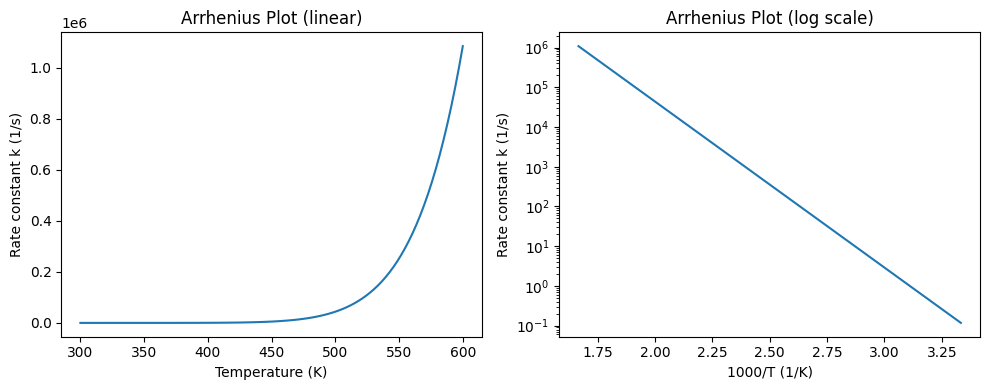

In [ ]:
# Arrhenius equation: k = A * exp(-Ea/RT)
A = 1e13  # 1/s
Ea = 80000  # J/mol
R = 8.314  # J/(mol·K)
T = np.linspace(300, 600, 100)

k = A * np.exp(-Ea / (R * T))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(T, k)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate constant k (1/s)')
plt.title('Arrhenius Plot (linear)')

plt.subplot(1, 2, 2)
plt.semilogy(1000/T, k)
plt.xlabel('1000/T (1/K)')
plt.ylabel('Rate constant k (1/s)')
plt.title('Arrhenius Plot (log scale)')

plt.tight_layout()
plt.show()

```{index} broadcasting
```


## Broadcasting: The Magic Behind NumPy's Elegance

Broadcasting is NumPy's way of handling operations between arrays of different shapes. It's what allows you to write `array + 5` (adding a scalar to every element) or multiply a matrix by a vector.

### How Broadcasting Works

When NumPy sees arrays of different shapes, it tries to make them compatible by:
1. Comparing dimensions from right to left
2. Dimensions match if they're equal, or if one of them is 1
3. Arrays with a dimension of 1 are "stretched" to match the other

### A Chemical Engineering Example

Suppose you want to calculate reaction rates at multiple temperatures AND multiple concentrations. Instead of writing nested loops, broadcasting does it in one line.

**The key**: Reshape one array so dimensions can be broadcast. `k.reshape(-1, 1)` makes k a column vector (5×1), and `C` stays a row (1×4). NumPy broadcasts to create a 5×4 grid of all combinations.

In [ ]:
# Calculate reaction rates at multiple T and C combinations
T = np.array([300, 350, 400, 450, 500])  # 5 temperatures
C = np.array([0.1, 0.5, 1.0, 2.0])  # 4 concentrations

# Rate = k * C, where k depends on T
k = A * np.exp(-Ea / (R * T))  # Shape: (5,)

# We want a 5x4 array of rates
# Reshape k to (5, 1) and C stays (4,) → broadcasts to (5, 4)
rates = k.reshape(-1, 1) * C

print("k shape:", k.shape)
print("C shape:", C.shape)
print("rates shape:", rates.shape)
print("\nRates (rows=T, cols=C):")
print(rates)

k shape: (5,)
C shape: (4,)
rates shape: (5, 4)

Rates (rows=T, cols=C):
[[1.17560001e-02 5.87800005e-02 1.17560001e-01 2.35120002e-01]
 [1.14874200e+00 5.74370998e+00 1.14874200e+01 2.29748399e+01]
 [3.57021760e+01 1.78510880e+02 3.57021760e+02 7.14043519e+02]
 [5.17018862e+02 2.58509431e+03 5.17018862e+03 1.03403772e+04]
 [4.38687994e+03 2.19343997e+04 4.38687994e+04 8.77375988e+04]]


```{index} aggregation, mean, std, min, max, median
```


## Aggregation Functions

In [ ]:
# Simulated experimental yields
yields = np.array([78.2, 82.1, 79.5, 81.3, 80.0, 79.8, 83.2, 77.9, 80.5, 81.1])

print(f"Mean: {np.mean(yields):.2f}%")
print(f"Std: {np.std(yields):.2f}%")
print(f"Min: {np.min(yields):.2f}%")
print(f"Max: {np.max(yields):.2f}%")
print(f"Median: {np.median(yields):.2f}%")

Mean: 80.36%
Std: 1.56%
Min: 77.90%
Max: 83.20%
Median: 80.25%


In [ ]:
# Aggregation along axes for 2D arrays
# Rows = different catalysts, Cols = replicate experiments
catalyst_yields = np.array([
    [78, 82, 79, 81, 80],  # Catalyst A
    [65, 68, 66, 64, 67],  # Catalyst B
    [88, 91, 89, 87, 90],  # Catalyst C
])

print("Mean per catalyst (across replicates):")
print(np.mean(catalyst_yields, axis=1))  # axis=1 means across columns

print("\nMean per replicate (across catalysts):")
print(np.mean(catalyst_yields, axis=0))  # axis=0 means across rows

Mean per catalyst (across replicates):
[80. 66. 89.]

Mean per replicate (across catalysts):
[77.         80.33333333 78.         77.33333333 79.        ]


```{index} linear algebra, np.linalg, matrix operations
```


## Linear Algebra

In [ ]:
# Solving linear systems: Ax = b
# Material balance: 3 reactions, 3 unknowns

# Stoichiometric matrix
coeff_matrix = np.array([
    [1, -1, 0],
    [0, 1, -1],
    [1, 0, 1]
])

# Right-hand side (inlet flows)
b = np.array([10, 5, 20])

# Solve
x = np.linalg.solve(coeff_matrix, b)
print("Solution x:", x)

# Verify: Ax should equal b
print("Verification coeff_matrix @ x:", coeff_matrix @ x)

Solution x: [17.5  7.5  2.5]
Verification coeff_matrix @ x: [10.  5. 20.]


In [ ]:
# Matrix operations
M = np.array([[1, 2], [3, 4]])

print("Determinant:", np.linalg.det(M))
print("\nInverse:")
print(np.linalg.inv(M))

eigenvalues, eigenvectors = np.linalg.eig(M)
print("\nEigenvalues:", eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

Determinant: -2.0000000000000004

Inverse:
[[-2.   1. ]
 [ 1.5 -0.5]]

Eigenvalues: [-0.37228132  5.37228132]

Eigenvectors:
[[-0.82456484 -0.41597356]
 [ 0.56576746 -0.90937671]]


```{index} file I/O, loadtxt, genfromtxt, save, load
```


## Reading Data from Files

Real data comes from files—CSV exports from instruments, text files from simulations, or datasets shared by colleagues. NumPy provides several functions for loading numerical data:

| Function | Best For | Features |
|----------|----------|----------|
| `np.loadtxt()` | Clean, simple data | Fast, simple API |
| `np.genfromtxt()` | Messy data with headers/missing values | Handles edge cases |
| `np.load()` / `np.save()` | NumPy binary format | Fast, preserves precision |

### When to Use What

- **Clean CSV with only numbers**: `np.loadtxt()` is fastest and simplest
- **Headers, missing values, or mixed types**: Use `np.genfromtxt()` or consider Pandas
- **Saving/loading NumPy arrays**: Use `np.save()` and `np.load()` for efficiency

**Pro tip**: For complex tabular data with mixed types and labels, Pandas (next module) is often easier. But for pure numerical data, NumPy's functions are fast and lightweight.

In [ ]:
# Download data files for the examples below
import urllib.request

base_url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/"

urllib.request.urlretrieve(base_url + "reactor_data.csv", "reactor_data.csv")
urllib.request.urlretrieve(base_url + "catalyst_experiments.txt", "catalyst_experiments.txt")

print("Data files downloaded: reactor_data.csv, catalyst_experiments.txt")

Data files downloaded: reactor_data.csv, catalyst_experiments.txt


In [ ]:
# Loading a simple CSV file with np.loadtxt()
# Skip header row, use comma delimiter
data = np.loadtxt('reactor_data.csv', delimiter=',', skiprows=1)

print("Shape:", data.shape)
print("Data type:", data.dtype)
print("\nFirst 3 rows:")
print(data[:3])

# Access columns by index
temp = data[:, 0]  # Temperature
pressure = data[:, 1]  # Pressure
flow = data[:, 2]  # Flow rate
conversion = data[:, 3]  # Conversion

print("\nTemperatures:", temp)
print("Conversions:", conversion)

Shape: (7, 4)
Data type: float64

First 3 rows:
[[350.    1.    2.5  45.2]
 [375.    1.2   2.8  52.1]
 [400.    1.5   3.   61.8]]

Temperatures: [350. 375. 400. 425. 450. 475. 500.]
Conversions: [45.2 52.1 61.8 68.4 74.9 79.3 83.7]


In [ ]:
# Loading data with headers using np.genfromtxt()
# This is more flexible than loadtxt - handles headers and missing values
data = np.genfromtxt('catalyst_experiments.txt', 
                     skip_header=1,  # Skip the header row
                     usecols=(1, 2, 3, 4))  # Skip the string column, use only numeric columns

print("Shape:", data.shape)
print("\nData (T, P, yield, selectivity):")
print(data)

Shape: (7, 4)

Data (T, P, yield, selectivity):
[[350.    1.   45.2  78.5]
 [375.    1.2  52.1  81.3]
 [400.    1.5  61.8  85.2]
 [425.    1.8  68.4  87.9]
 [450.    2.   74.9  89.1]
 [475.    2.2  79.3  90.4]
 [500.    2.5  83.7  91.8]]


In [ ]:
# Saving and loading NumPy arrays (binary format)
# This is the fastest way to save/load NumPy arrays

# Save an array
temps = np.array([300, 350, 400, 450, 500])
np.save('temperatures.npy', temps)

# Load it back
temps_loaded = np.load('temperatures.npy')
print("Loaded array:", temps_loaded)

# Save multiple arrays in one file
np.savez('experiment.npz', temperature=temps, conversion=conversion)

# Load multiple arrays
loaded = np.load('experiment.npz')
print("\nArrays in file:", list(loaded.keys()))
print("Temperature:", loaded['temperature'])
print("Conversion:", loaded['conversion'])

Loaded array: [300 350 400 450 500]

Arrays in file: ['temperature', 'conversion']
Temperature: [300 350 400 450 500]
Conversion: [45.2 52.1 61.8 68.4 74.9 79.3 83.7]


```{index} structured arrays, record arrays, dtype
```


## Structured Arrays (Record Arrays)

Sometimes you need to work with heterogeneous data—not just numbers, but mixed types with named fields. NumPy's **structured arrays** (also called record arrays) allow you to define a custom data type with named fields of different types.

### When to Use Structured Arrays

- **Small datasets with mixed types**: When you need names but not full Pandas overhead
- **Interfacing with C/Fortran code**: Structured arrays map directly to C structs
- **Memory-mapped files**: Efficient access to large datasets on disk
- **Performance-critical code**: Faster than Pandas for simple operations

### When to Use Pandas Instead

For most tabular data work, **Pandas is easier and more feature-rich**. Use structured arrays when:
- You need maximum performance for simple operations
- You're interfacing with low-level code
- You want to keep dependencies minimal

Think of structured arrays as "labeled arrays" and Pandas as "database tables."

In [ ]:
# Creating a structured array with a custom dtype
# Define the data type: (field_name, field_type)
dt = np.dtype([
    ('temperature', 'f8'),  # 64-bit float
    ('pressure', 'f8'),     # 64-bit float
    ('conversion', 'f8'),   # 64-bit float
    ('catalyst', 'U10')     # Unicode string, max 10 chars
])

# Create the structured array
experiments = np.array([
    (350.0, 1.0, 45.2, 'Pt/Al2O3'),
    (400.0, 1.5, 62.8, 'Pd/C'),
    (450.0, 2.0, 75.4, 'Ni/SiO2'),
    (500.0, 2.5, 83.1, 'Pt/Al2O3'),
], dtype=dt)

print("Structured array:")
print(experiments)
print("\nShape:", experiments.shape)
print("Dtype:", experiments.dtype)
print("Field names:", experiments.dtype.names)

Structured array:
[(350., 1. , 45.2, 'Pt/Al2O3') (400., 1.5, 62.8, 'Pd/C')
 (450., 2. , 75.4, 'Ni/SiO2') (500., 2.5, 83.1, 'Pt/Al2O3')]

Shape: (4,)
Dtype: [('temperature', '<f8'), ('pressure', '<f8'), ('conversion', '<f8'), ('catalyst', '<U10')]
Field names: ('temperature', 'pressure', 'conversion', 'catalyst')


In [ ]:
# Accessing fields by name - much clearer than column indices!
print("All temperatures:", experiments['temperature'])
print("All catalysts:", experiments['catalyst'])

# Access a single record (row)
print("\nFirst experiment:", experiments[0])
print("First experiment temp:", experiments[0]['temperature'])

# Boolean indexing works too
high_conv = experiments[experiments['conversion'] > 60]
print("\nHigh conversion experiments:")
print(high_conv)

# Find experiments with Pt catalyst
pt_experiments = experiments[experiments['catalyst'] == 'Pt/Al2O3']
print("\nPt/Al2O3 experiments:")
print(pt_experiments)

All temperatures: [350. 400. 450. 500.]
All catalysts: ['Pt/Al2O3' 'Pd/C' 'Ni/SiO2' 'Pt/Al2O3']

First experiment: (350.0, 1.0, 45.2, 'Pt/Al2O3')
First experiment temp: 350.0

High conversion experiments:
[(400., 1.5, 62.8, 'Pd/C') (450., 2. , 75.4, 'Ni/SiO2')
 (500., 2.5, 83.1, 'Pt/Al2O3')]

Pt/Al2O3 experiments:
[(350., 1. , 45.2, 'Pt/Al2O3') (500., 2.5, 83.1, 'Pt/Al2O3')]


In [ ]:
# Loading structured data from a file with genfromtxt
# Define the dtype to match the file structure
dt = np.dtype([
    ('catalyst_id', 'U10'),
    ('temperature', 'f8'),
    ('pressure', 'f8'),
    ('yield', 'f8'),
    ('selectivity', 'f8')
])

# Load with dtype specification
data = np.genfromtxt('catalyst_experiments.txt', 
                     dtype=dt,
                     skip_header=1)

print("Loaded structured array:")
print(data)
print("\nAccess by field name:")
print("Catalyst IDs:", data['catalyst_id'])
print("Mean yield:", np.mean(data['yield']))

Loaded structured array:
[('A1', 350., 1. , 45.2, 78.5) ('A2', 375., 1.2, 52.1, 81.3)
 ('B1', 400., 1.5, 61.8, 85.2) ('B2', 425., 1.8, 68.4, 87.9)
 ('C1', 450., 2. , 74.9, 89.1) ('C2', 475., 2.2, 79.3, 90.4)
 ('D1', 500., 2.5, 83.7, 91.8)]

Access by field name:
Catalyst IDs: ['A1' 'A2' 'B1' 'B2' 'C1' 'C2' 'D1']
Mean yield: 66.4857142857143


### Common dtype codes

| Code | Type | Example |
|------|------|---------|
| `'f4'` | 32-bit float | `np.float32` |
| `'f8'` | 64-bit float | `np.float64` |
| `'i4'` | 32-bit integer | `np.int32` |
| `'i8'` | 64-bit integer | `np.int64` |
| `'U10'` | Unicode string (10 chars) | Fixed-length string |
| `'S10'` | Byte string (10 bytes) | ASCII only |
| `'?'` | Boolean | True/False |

**Tip**: Use `'f8'` (64-bit float) as your default for numerical data—it matches Python's `float` precision.

```{index} random numbers, random number generator, seeding, reproducibility
```


## Random Numbers: Essential for Simulation

Random number generation is fundamental to many scientific applications:

- **Monte Carlo simulation**: Propagating uncertainty, sampling from distributions
- **Machine learning**: Initializing weights, shuffling data, dropout
- **Process simulation**: Modeling noise, disturbances, variability
- **Experimental design**: Random sampling, bootstrap resampling

### NumPy's Random Number Generator

Modern NumPy (1.17+) uses a new random number generator API. The recommended approach is:

```python
rng = np.random.default_rng(seed=42)  # Create a generator with a seed
```

**Why use a seed?** Seeds make your results reproducible. Running the same code twice with the same seed gives identical "random" numbers. This is essential for:
- Debugging (reproducing exactly what happened)
- Sharing results (others can reproduce your analysis)
- Testing (consistent behavior across runs)

**When NOT to seed**: When you genuinely need randomness (cryptography, production sampling)

```{index} Monte Carlo simulation, uncertainty propagation
```


This Monte Carlo simulation demonstrates **uncertainty propagation**—a critical skill for engineering.

**What we did**:
1. Our temperature measurement is uncertain: T = 400 ± 5 K (about 1.25% uncertainty)
2. We sampled 10,000 possible temperatures from this distribution
3. We calculated k for each sampled temperature
4. We analyzed the resulting distribution of k values

**What we learned**:
- The input (T) is normally distributed and symmetric
- The output (k) is **not** normally distributed—it's skewed!
- A small uncertainty in T (1.25%) creates a much larger uncertainty in k (≈20-30%)

This asymmetric amplification happens because k depends *exponentially* on T. The Arrhenius equation is highly nonlinear, so symmetric input uncertainty becomes asymmetric output uncertainty.

**Engineering implication**: When designing experiments or processes, you must propagate uncertainties through your models. The final uncertainty in your prediction can be much larger (or smaller) than the measurement uncertainties you started with.

In [ ]:
# Set seed for reproducibility
rng = np.random.default_rng(42)

# Uniform random numbers
uniform = rng.uniform(0, 1, 5)
print("Uniform [0,1):", uniform)

# Normal distribution (Gaussian)
normal = rng.normal(loc=50, scale=5, size=5)  # mean=50, std=5
print("Normal (μ=50, σ=5):", normal)

# Random integers
integers = rng.integers(1, 100, 5)
print("Random integers [1, 100):", integers)

Uniform [0,1): [0.77395605 0.43887844 0.85859792 0.69736803 0.09417735]
Normal (μ=50, σ=5): [43.48910247 50.63920202 48.41878704 49.91599421 45.73478036]
Random integers [1, 100): [50 37 19 92 78]


k = 3.7108e+02 ± 1.1373e+02


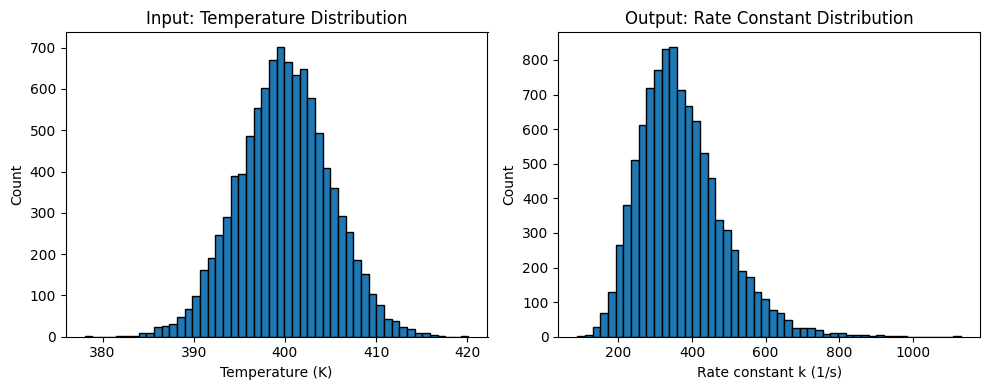

In [ ]:
# Monte Carlo simulation: Propagating measurement uncertainty
# Measure temperature: T = 400 ± 5 K
# What's the uncertainty in rate constant k?

rng = np.random.default_rng(42)
n_samples = 10000

# Sample temperatures from normal distribution
T_samples = rng.normal(400, 5, n_samples)

# Calculate k for each sample
k_samples = A * np.exp(-Ea / (R * T_samples))

print(f"k = {np.mean(k_samples):.4e} ± {np.std(k_samples):.4e}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(T_samples, bins=50, edgecolor='black')
axes[0].set_xlabel('Temperature (K)')
axes[0].set_ylabel('Count')
axes[0].set_title('Input: Temperature Distribution')

axes[1].hist(k_samples, bins=50, edgecolor='black')
axes[1].set_xlabel('Rate constant k (1/s)')
axes[1].set_ylabel('Count')
axes[1].set_title('Output: Rate Constant Distribution')

plt.tight_layout()
plt.show()

```{index} views vs copies, common pitfalls
```


## Common Pitfalls: Mistakes Everyone Makes

NumPy has some non-obvious behaviors that trip up beginners (and sometimes experts). Understanding these will save you debugging time.

### 1. Views vs Copies

This is the most common source of NumPy bugs. When you slice an array, you get a **view**, not a copy. Modifying the view modifies the original!

In [ ]:
# Pitfall 1: Views vs Copies
a = np.array([1, 2, 3, 4, 5])
b = a[1:4]  # This is a VIEW, not a copy!

b[0] = 99  # This modifies 'a' too!
print("a:", a)  # [1, 99, 3, 4, 5]

# Use .copy() if you need an independent copy
a = np.array([1, 2, 3, 4, 5])
b = a[1:4].copy()
b[0] = 99
print("a (with copy):", a)  # [1, 2, 3, 4, 5]

a: [ 1 99  3  4  5]
a (with copy): [1 2 3 4 5]


In [27]:
# Pitfall 2: Integer division
a = np.array([1, 2, 3])  # Integer array
print("Integer array / 2:", a / 2)  # Fine, returns floats

# But be careful with floor division
print("Integer array // 2:", a // 2)  # Integer division

Integer array / 2: [0.5 1.  1.5]
Integer array // 2: [0 1 1]


In [28]:
# Pitfall 3: Shape mismatches
a = np.array([1, 2, 3])
b = np.array([1, 2])  # Different length!

try:
    c = a + b
except ValueError as e:
    print("Error:", e)

Error: operands could not be broadcast together with shapes (3,) (2,) 


---

## The Catalyst Crisis: "The Long Loop"

*Continued from Introduction...*

---

Alex's code had been running for twelve minutes.

She watched the progress bar crawl across her screen, each percentage point taking an eternity. All she was doing was calculating summary statistics for the ChemCorp sensor data—10,000 rows, nothing fancy. But her nested loops were grinding through the data like a car stuck in first gear.

"That's... a lot of for loops."

Alex turned to find Maya peering at her screen with the expression of someone watching a car accident.

"It works," Alex said defensively.

"It works like a horse-drawn carriage works. Technically functional. Here—" Maya pulled up a chair. "Can I show you something?"

She typed a few lines, replacing Alex's twelve nested loops with something that looked almost too simple:

```python
means = data.mean(axis=0)
stds = data.std(axis=0)
```

The code finished in 0.3 seconds.

"NumPy doesn't loop through elements," Maya explained. "It operates on entire arrays at once. The loop still happens, but in compiled C code, not interpreted Python."

Alex stared at the output. Same numbers. Fraction of the time. "I spent three hours writing that loop structure."

"And now you'll never write it again." Maya grinned. "That's learning, right?"

Later that night, Alex sat in the graduate student lounge, reworking her analysis with vectorized operations. The ChemCorp data transformed from an unwieldy beast into something almost manageable. She could process a day's worth of sensor readings in seconds instead of minutes.

But something else caught her attention. As she explored the data, she noticed gaps—timestamps where sensors should have reported but didn't. Not random gaps. Clusters of missing values, always during the same time windows.

She opened her notebook—the physical one, old habit from industry—and sketched the pattern. Gaps at 11 PM. Gaps at 3 AM. Gaps at 7 AM.

Shift changes.

She didn't know what it meant yet. But she'd learned something today: the data wasn't just numbers. It was evidence. And evidence always told a story if you knew how to listen.

She added a sticky note to the mystery board: **Missing data clusters around shift changes. Why?**

*To be continued...*

## Self-Assessment Quiz

Test your understanding of NumPy fundamentals with this quiz.

In [29]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/01-numpy/quizzes/numpy-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources will deepen your understanding of NumPy and numerical computing:

1. **[NumPy User Guide](https://numpy.org/doc/stable/user/index.html)** - The official NumPy documentation with comprehensive coverage of array creation, indexing, broadcasting, and linear algebra. The "NumPy fundamentals" section is particularly valuable.

2. **[From Python to NumPy by Nicolas Rougier](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)** - A free online book that takes you from Python basics to advanced NumPy techniques. Excellent explanations of vectorization and why it matters for performance.

3. **[NumPy: the absolute basics for beginners](https://numpy.org/doc/stable/user/absolute_beginners.html)** - Official beginner's guide that covers array fundamentals, broadcasting rules, and common operations with clear examples.

4. **[100 NumPy Exercises](https://github.com/rougier/numpy-100)** - A collection of exercises ranging from beginner to expert level. Great for practicing and solidifying your NumPy skills.

5. **[Array Programming with NumPy (Harris et al., Nature 2020)](https://www.nature.com/articles/s41586-020-2649-2)** - The definitive paper on NumPy's design and its role in scientific computing. Provides context for why NumPy is the foundation of the Python scientific ecosystem.

## Summary: NumPy Mindset

NumPy requires a different way of thinking about computation. Here's what to remember:

### Core Concepts

| Concept | Key Idea | Why It Matters |
|---------|----------|----------------|
| **Arrays** | Homogeneous, typed containers | 10-100x faster than lists |
| **Vectorization** | Operate on entire arrays | Eliminates slow Python loops |
| **Broadcasting** | Automatic shape matching | Clean code, fewer bugs |
| **Views** | Slices share memory | Fast, but be careful with modifications |
| **File I/O** | `loadtxt`, `genfromtxt`, `save/load` | Work with real data from files |
| **Structured Arrays** | Named fields with mixed types | Bridge between arrays and tables |

### When to Use NumPy

- Any numerical computation with arrays of numbers
- Building blocks for machine learning features
- Scientific calculations (physics, chemistry, engineering)
- Image and signal processing
- Loading simple numerical data from CSV/text files

### When to Use Pandas Instead

- Tabular data with labeled columns
- Mixed data types (numbers, strings, dates)
- Time series with datetime indices
- Data cleaning and exploration
- Complex data with many column types and labels

### Key Takeaways

1. **Think in arrays**: Write operations that apply to whole arrays, not individual elements
2. **Avoid loops**: If you're writing a for loop over array elements, there's probably a better way
3. **Scale matters**: Always scale/normalize features before combining them
4. **Copy when needed**: Use `.copy()` if you need to modify a slice without affecting the original
5. **Seed for reproducibility**: Always set a random seed for reproducible results
6. **Choose the right loader**: Use `loadtxt` for clean data, `genfromtxt` for messy data, Pandas for complex tabular data

## Next Steps

In the next module, we'll learn Pandas, which builds on NumPy to provide labeled data structures for tabular data. If NumPy is the engine, Pandas is the dashboard—same power, but easier to interact with for real-world data.